In [1]:
#import sys
#sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        u_tt = torch.autograd.grad(
            u_t, t, 
            grad_outputs=torch.ones_like(u_t),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_tt + u_xx + 6*u-(x+1)*(x-1)-(t+1)*(t-1)-3*(x+1)*(x-1)*(t+1)*(t-1)-(6-10*torch.pi*torch.pi)*torch.sin(torch.pi*x)*torch.sin(3*torch.pi*t) 
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [4]:
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('burgers_shock.mat')

t = data['x'].flatten()[:,None]
x = data['x'].flatten()[:,None]

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
#u_star = Exact.flatten()[:,None]              

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)    

# X axis at y=-1
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = np.repeat(0,xx1.shape[0]).flatten()[:,None] 

# X axis at y=1
#xx2 = np.hstack((X[:,0:1], T[:,0:1]))
xx2 = np.hstack((X[0:1,:].T, T[-1:,:].T))
uu2 = np.repeat(0,xx2.shape[0]).flatten()[:,None] 

# Y axis at x=-1
xx3 = np.hstack((X[:,0:1], T[:,-1:]))
uu3 = np.repeat(0,xx3.shape[0]).flatten()[:,None] 

# Y axis at x=1 
xx4 = np.hstack((X[:,-1:], T[:,-1:]))
uu4 = np.repeat(0,xx4.shape[0]).flatten()[:,None] 

X_u_train = np.vstack([xx1, xx2, xx3, xx4])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3, uu4])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

In [5]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub)


In [6]:
model.train()


Iter 100, Loss: 1.22694e+03, Loss_u: 9.35926e-01, Loss_f: 1.22601e+03
Iter 200, Loss: 3.57772e+02, Loss_u: 1.09697e+01, Loss_f: 3.46803e+02
Iter 300, Loss: 8.74822e+01, Loss_u: 1.82426e+01, Loss_f: 6.92396e+01
Iter 400, Loss: 2.48915e+01, Loss_u: 5.10404e+00, Loss_f: 1.97875e+01
Iter 500, Loss: 8.36042e+00, Loss_u: 2.78500e+00, Loss_f: 5.57542e+00
Iter 600, Loss: 3.82065e+00, Loss_u: 9.45210e-01, Loss_f: 2.87544e+00
Iter 700, Loss: 2.37463e+00, Loss_u: 5.57051e-01, Loss_f: 1.81758e+00
Iter 800, Loss: 1.50094e+00, Loss_u: 2.65777e-01, Loss_f: 1.23516e+00
Iter 900, Loss: 9.82378e-01, Loss_u: 1.07356e-01, Loss_f: 8.75022e-01
Iter 1000, Loss: 6.26872e-01, Loss_u: 5.77980e-02, Loss_f: 5.69074e-01
Iter 1100, Loss: 4.79499e-01, Loss_u: 6.23850e-02, Loss_f: 4.17114e-01
Iter 1200, Loss: 4.02560e-01, Loss_u: 4.61441e-02, Loss_f: 3.56416e-01
Iter 1300, Loss: 3.28262e-01, Loss_u: 3.27201e-02, Loss_f: 2.95542e-01
Iter 1400, Loss: 2.74412e-01, Loss_u: 2.62768e-02, Loss_f: 2.48136e-01
Iter 1500, Loss

In [26]:
u_pred, f_pred = model.predict(X_star)
Exact = 0.5*(X + 1)*(X-1)*(T+1)*(T-1) + np.sin(np.pi*X)*np.sin(3*np.pi*T) 
#u_star = Exact.flatten()[:,None]

#error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
#print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

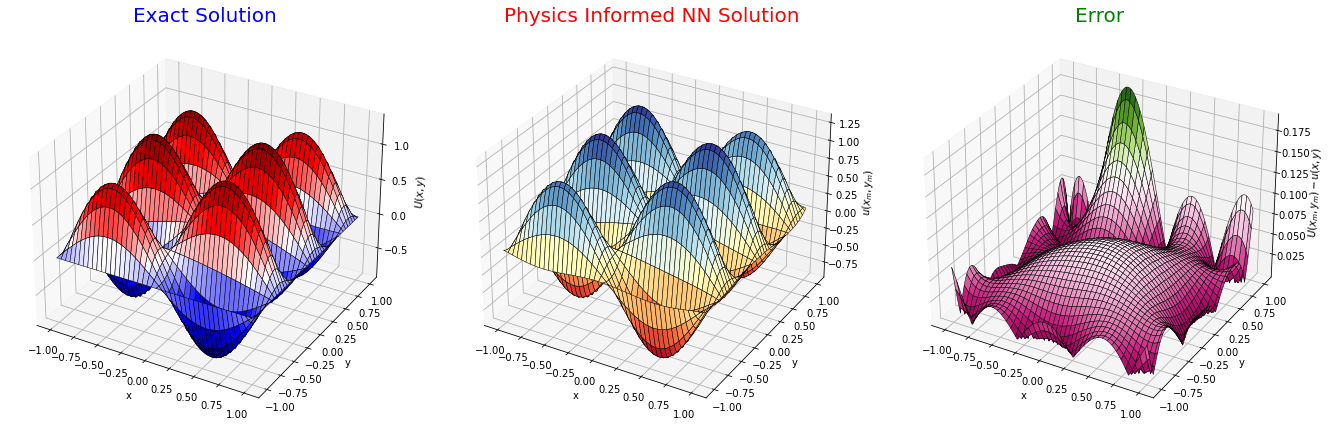

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm



# Plotting
fig = plt.figure(figsize=(25,12))



ax = fig.add_subplot(211, projection='3d')

ax.set_title("Physics Informed NN Solution", fontsize=20,color="red")

ax.plot_surface(X, T, U_pred, cmap=cm.RdYlBu, linewidth=0.5, edgecolors='k')

ax.set_xlabel("x",fontsize = 10)
ax.set_ylabel("y",fontsize = 10)
ax.set_zlabel(r"$u(x_{m},y_{m})$",fontsize = 10)


ax = fig.add_subplot(221, projection='3d')

ax.set_title("Exact Solution", fontsize=20,color="blue")

ax.plot_surface(X, T, Exact, cmap=cm.seismic, linewidth=0.5, edgecolors='k')

ax.set_xlabel("x",fontsize = 10)
ax.set_ylabel("y",fontsize = 10)
ax.set_zlabel(r"$U(x,y)$",fontsize = 10)



ax = fig.add_subplot(222, projection='3d')

ax.set_title("Error", fontsize=20,color="green")

ax.plot_surface(X, T, Error, cmap=cm.PiYG, linewidth=0.5, edgecolors='k')

ax.set_xlabel("x",fontsize = 10)
ax.set_ylabel("y",fontsize = 10)
ax.set_zlabel(r"$U(x_{m},y_{m}) - u(x,y)$",fontsize = 10)


plt.tight_layout()
plt.show()